In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score, silhouette_score,
                             davies_bouldin_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import streamlit as st
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor  

In [2]:
def load_data():
    train = pd.read_csv( r"C:\Users\abims\Downloads\train_data_con.csv")
    test = pd.read_csv(r"C:\Users\abims\Downloads\test_data _con.csv")
    return train, test

train_df, test_df = load_data()

In [3]:
# Create target columns
def create_targets(df):
    if 'order' not in df.columns:
        raise KeyError("The 'order' column is missing from the DataFrame. Please verify the input data.")
   
    df['converted'] = df['order'].apply(lambda x: 1 if 'checkout' in str(x).lower() else 0)
    df['revenue'] = df.groupby('session_id')['price'].transform('sum')
    return df

train_df = create_targets(train_df)
test_df = create_targets(test_df)

In [4]:
# Aggregate session data
def aggregate_session_data(df):
    session_df = df.groupby('session_id').agg({
        'page1_main_category': 'nunique',
        'page2_clothing_model': 'count',
        'colour': 'nunique',
        'price': 'sum',
        'converted': 'max',
        'revenue': 'max',
        'country': 'first',               
        'model_photography': 'first'      
    }).reset_index()
    session_df.rename(columns={
        'page1_main_category': 'unique_categories',
        'page2_clothing_model': 'total_clicks',
        'colour': 'unique_colors'
    }, inplace=True)
    return session_df
train_session = aggregate_session_data(train_df)
test_session = aggregate_session_data(test_df)

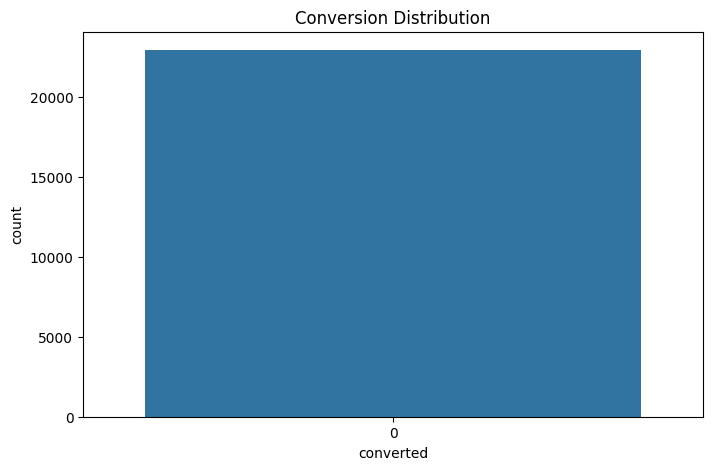

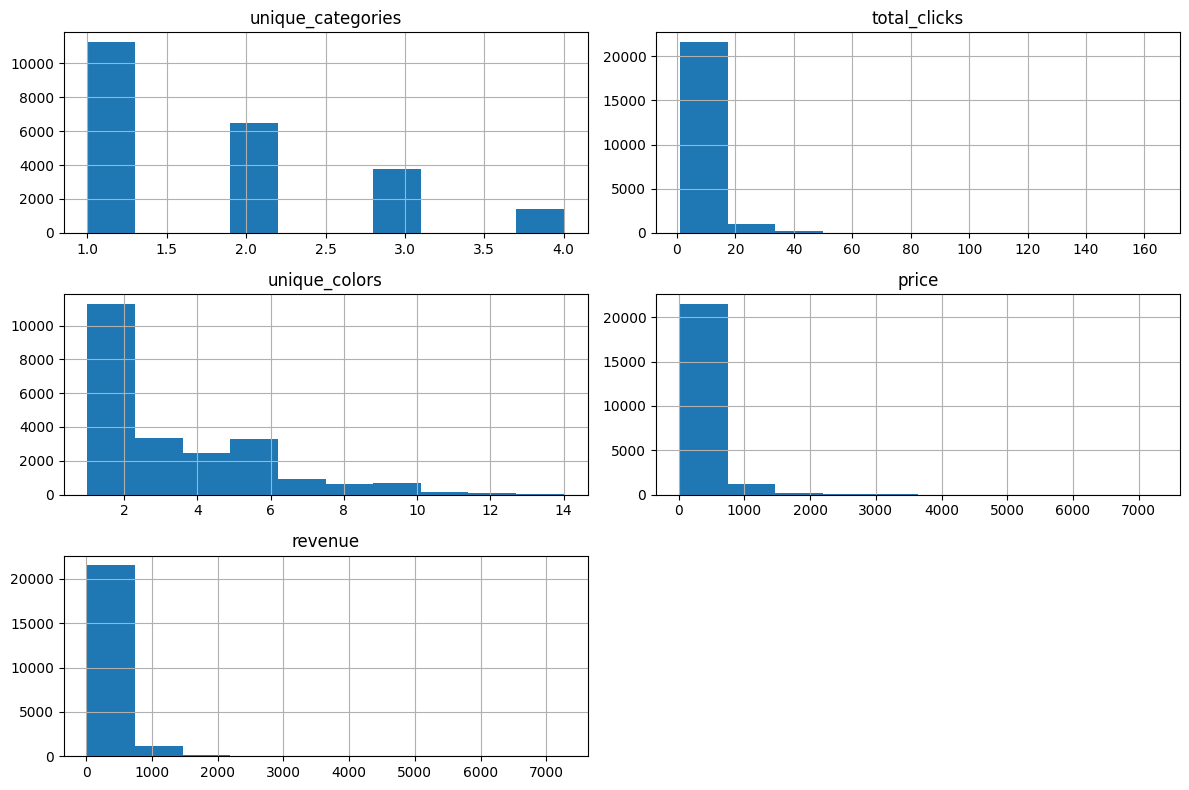

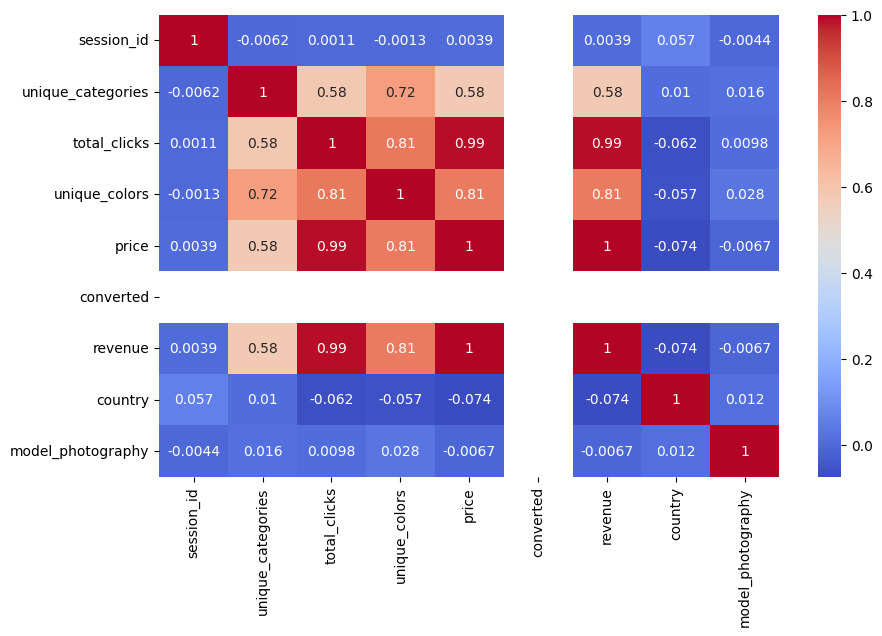

In [5]:
def perform_eda(df):
   

    # Time-based Analysis
    if 'SESSION START' in df.columns:
        df['hour'] = pd.to_datetime(df['SESSION START']).dt.hour
        df['day_of_week'] = pd.to_datetime(df['SESSION START']).dt.day_name()

    # Conversion distribution
# Show or configure Matplotlib plot
    plt.figure(figsize=(8,5))
# Plotting with Seaborn
    sns.countplot(x='converted', data=df)
# Show or configure Matplotlib plot
    plt.title('Conversion Distribution')
# Show or configure Matplotlib plot
    plt.show()
    #st.pyplot(plt)

    # Numerical feature distributions
    df[['unique_categories', 'total_clicks', 'unique_colors', 'price', 'revenue']].hist(figsize=(12,8))
# Show or configure Matplotlib plot
    plt.tight_layout()
    # st.pyplot(plt)
# Show or configure Matplotlib plot
    plt.show()

    # Correlation heatmap
# Show or configure Matplotlib plot
    plt.figure(figsize=(10,6))
# Plotting with Seaborn
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    #st.pyplot(plt)
# Show or configure Matplotlib plot
    plt.show()
   


perform_eda(train_session)

In [6]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['price_per_click'] = X['price'] / (X['total_clicks'] + 1)
        X['color_diversity'] = X['unique_colors'] / (X['total_clicks'] + 1)
        X['session_length'] = X['total_clicks']
        X['bounce_rate'] = (X['total_clicks'] == 1).astype(int)
        X['exit_rate'] = X['total_clicks'] / (X['unique_categories'] + 1)
        return X

#Preprocessing Pipeline
numeric_features = ['unique_categories', 'total_clicks', 'unique_colors', 'price', 'price_per_click', 'color_diversity']
categorical_features = ['country', 'model_photography']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

full_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor)
])

In [7]:
#Preprocessing Pipeline
numeric_features = ['unique_categories', 'total_clicks', 'unique_colors', 'price', 'price_per_click', 'color_diversity']
categorical_features = ['country', 'model_photography']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

full_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor)
])

In [8]:
# 🔄 Clustering Metrics

def evaluate_clustering(name,X, labels):
    print(f"--- Clustering Metrics {name}---")
    print(f"Silhouette Score  {name}:", silhouette_score(X, labels))                   # 🔄
    print(f"Davies-Bouldin Index  {name}:", davies_bouldin_score(X, labels))          # 🔄

    # WCSS (Within-Cluster Sum of Squares)
    kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42)      # 🔄
    kmeans.fit(X)                                                             # 🔄
    print(f"WCSS  {name}:", kmeans.inertia_)                                          # 🔄

In [9]:
# Clustering Models
with mlflow.start_run(run_name="Clustering"):
    clustering_models = {
        'K-Means': KMeans(n_clusters=3, random_state=42),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
        'Agglomerative Clustering': AgglomerativeClustering(n_clusters=3)
    }
    
    for name, model in clustering_models.items():
        print(f"Training {name}...")
        cluster_pipeline = Pipeline([
            ('full_pipeline', full_pipeline),
            ('clustering', model)
        ])
        
        cluster_pipeline.fit(train_session.drop(['converted', 'revenue', 'session_id'], axis=1))
        mlflow.sklearn.log_model(cluster_pipeline, f"{name}_model")
        pickle.dump(cluster_pipeline, open(f'best_{name.replace(" ", "_").lower()}.pkl', 'wb'))
        X_cluster = full_pipeline.fit_transform(train_session.drop(['converted', 'revenue', 'session_id'], axis=1))
        kmeans = KMeans(n_clusters=3, random_state=42)
        labels = kmeans.fit_predict(X_cluster)
        evaluate_clustering(name,X_cluster, labels)

Training K-Means...


2025/04/09 17:16:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Clustering Metrics K-Means---
Silhouette Score  K-Means: 0.4265998747302813
Davies-Bouldin Index  K-Means: 1.3499776431922135
WCSS  K-Means: 11304.458768399569
Training DBSCAN...


2025/04/09 17:17:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/09 17:17:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Clustering Metrics DBSCAN---
Silhouette Score  DBSCAN: 0.4265998747302813
Davies-Bouldin Index  DBSCAN: 1.3499776431922135
WCSS  DBSCAN: 11304.458768399569
Training Agglomerative Clustering...


2025/04/09 17:18:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/09 17:18:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Clustering Metrics Agglomerative Clustering---
Silhouette Score  Agglomerative Clustering: 0.4265998747302813
Davies-Bouldin Index  Agglomerative Clustering: 1.3499776431922135
WCSS  Agglomerative Clustering: 11304.458768399569


In [ ]:
# Ensure Pipeline is used in Classification
y_class = train_session['converted']
X = train_session.drop(['converted', 'revenue', 'session_id'], axis=1)


test_X = test_session.drop(['converted', 'revenue', 'session_id'], axis=1)

smote = SMOTE(random_state=42)

if len(np.unique(y_class)) > 1:
    X_resampled, y_resampled = smote.fit_resample(X, y_class)
else:
    print("SMOTE skipped: Only one class present in y_class")
    X_resampled, y_resampled = X, y_class  

SMOTE skipped: Only one class present in y_class


In [11]:
#Classification Section
mlflow.set_experiment("Customer_Conversion_Analysis")

<Experiment: artifact_location='file:///C:/Users/abims/Documents/ClickStream/clickStream_CustomerConversion/mlruns/452161899125636182', creation_time=1740387303189, experiment_id='452161899125636182', last_update_time=1740387303189, lifecycle_stage='active', name='Customer_Conversion_Analysis', tags={}>

In [12]:
# Classification Metrics

def evaluate_classification(name,y_true, y_pred, y_proba=None):
    print(f"--- Classification Metrics for {name}---")
    print(f"Accuracy for {name}: ", accuracy_score(y_true, y_pred))                         # 
    print(f"Precision for {name}: ", precision_score(y_true, y_pred))                       # 
    print(f"Recall for {name}: ", recall_score(y_true, y_pred))                             # 
    print(f"F1-Score for {name}: ", f1_score(y_true, y_pred))                               # 
    if y_proba is not None:
        print(f"ROC-AUC Score for {name} :", roc_auc_score(y_true, y_proba))               # 

In [ ]:
if len(np.unique(y_resampled)) > 1:
    with mlflow.start_run(run_name="Classification"):
        classifiers = {
            'Logistic Regression': LogisticRegression(),
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(),
            'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            'Neural Network': MLPClassifier()
        }
        
        for name, model in classifiers.items():
            print(f"Training {name}...")
            class_pipeline = Pipeline([
                ('full_pipeline', full_pipeline),
                ('classifier', model)
            ])
            
            class_pipeline.fit(X_resampled, y_resampled)
            mlflow.sklearn.log_model(class_pipeline, f"{name}_model")
            pickle.dump(class_pipeline, open(f'best_{name.replace(" ", "_").lower()}.pkl', 'wb'))
            y_pred = class_pipeline.predict(X_resampled)
            y_proba = class_pipeline.predict_proba(X_resampled)[:, 1]

            # 🔄 Evaluate metrics
            evaluate_classification(name,y_resampled, y_pred, y_proba)
#  Regression Section
X_reg = train_session.drop(['converted', 'revenue', 'session_id'], axis=1)
y_reg = train_session['revenue']

1


In [14]:
# Regression Metrics

def evaluate_regression(name,y_true, y_pred):
    print(f"--- Regression Metrics {name}---")
    print(f"MAE {name} :", mean_absolute_error(y_true, y_pred))                         # 
    print(f"MSE {name}:", mean_squared_error(y_true, y_pred))                          # 
    print(f"RMSE {name}:", np.sqrt(mean_squared_error(y_true, y_pred)))               # 
    print(f"R-squared {name}:", r2_score(y_true, y_pred))                              # 

In [15]:
with mlflow.start_run(run_name="Regression"):
    regressors = {
        'Linear Regression': LinearRegression(),  
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }

    for name, model in regressors.items():
        print(f"Training {name}...")
        reg_pipeline = Pipeline([
            ('full_pipeline', full_pipeline),
            ('regressor', model)
        ])

        reg_pipeline.fit(X_reg, y_reg)
        mlflow.sklearn.log_model(reg_pipeline, f"{name}_model")
        pickle.dump(reg_pipeline, open(f'best_{name.replace(" ", "_").lower()}.pkl', 'wb'))
        reg_pipeline.fit(X_reg, y_reg)

        y_pred_reg = reg_pipeline.predict(X_reg)
        evaluate_regression(name,y_reg, y_pred_reg)

Training Linear Regression...


2025/04/09 17:19:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Regression Metrics Linear Regression---
MAE Linear Regression : 1.1486501279209375e-11
MSE Linear Regression: 1.3342168657308244e-22
RMSE Linear Regression: 1.1550830557716724e-11
R-squared Linear Regression: 1.0
Training Ridge Regression...


2025/04/09 17:19:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Regression Metrics Ridge Regression---
MAE Ridge Regression : 9.195981831277262
MSE Ridge Regression: 235.49940721210282
RMSE Ridge Regression: 15.345989939137286
R-squared Ridge Regression: 0.9976410498250757
Training Lasso Regression...


2025/04/09 17:19:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Regression Metrics Lasso Regression---
MAE Lasso Regression : 15.828947788093497
MSE Lasso Regression: 1429.4356679766106
RMSE Lasso Regression: 37.80787838502196
R-squared Lasso Regression: 0.98568163054449
Training Gradient Boosting Regressor...


2025/04/09 17:19:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Regression Metrics Gradient Boosting Regressor---
MAE Gradient Boosting Regressor : 1.7313100656341083
MSE Gradient Boosting Regressor: 9.999630945014836
RMSE Gradient Boosting Regressor: 3.1622193069132374
R-squared Gradient Boosting Regressor: 0.9998998357089465
